In [606]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

## Learning Concepts

In this notebook, we experiment with how to learn the function $f(c|...)$ which models a set of inputs to the ouput concept. The dataset used here is generated in the windy gridworld environment. The following conditional relationships will be explored:

* $f(c|s)$
* $f(c|s,a)$
* $f(c|s,a,s')$
* $f(c|s,a,r_{s}$ where $r_s$ is the short term reward
* $f(c|s,a,r_{l})$ where $r_l$ is the longer term reward
* $f(c|s,a,\bar{s})$ where $\bar{s}$ may indicate the k-NN of state s for example
* $f(c|s,a,\theta)$ where $\theta$ is some unknown parameter

A MLP will be used to model these functions in order to learn a mapping from the set of inputs to the concept.


In [622]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("dataset_large.npz") #We're using dataset_large and dataset_knn
print(np.array(trajectories, dtype=object).shape)
print(np.array(rewards).shape)
print(np.array(unique_concepts, dtype=object).shape)
print(np.array(concepts, dtype=object).shape)
print(np.array(actions, dtype=object).shape)
print(means.shape)
print(clusters.shape)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(653,)
(653,)
(653,)
(653,)
(653,)
(5, 2)
(500, 2)


## Preprocessing

Apply any preprocessing at this point.

In [658]:
num_concepts = len(means)
up = np.array([0, 1])
down = np.array([0, -1])
right = np.array([1, 0])
left = np.array([-1, 0])

A = np.array([up, down, right, left])


def generate_default_dataset(window_size):
    Y = np.concatenate(concepts)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def generate_states_actions_dataset():
    '''Adds third element to input vector which is the action taken in the current state'''
    Y = np.concatenate(concepts)
    X = np.concatenate(window_states(trajectories))
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    actions_indexed = actions_indexed.reshape(len(actions_indexed), 1)
    X = np.concatenate((X, actions_indexed), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def generate_states_voted_actions_dataset():
    '''Adds third element to input vector which is the action taken in the current state'''
    Y = np.concatenate(concepts)
    X = np.concatenate(window_states(trajectories))
    actions_voted = np.concatenate(generate_voted_actions(w_size=5))
    actions_voted = actions_voted.reshape(len(actions_voted), 1)
    X = np.concatenate((X, actions_voted), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def generate_states_next_states_dataset():
    ''''''
    windowed_states = window_states(trajectories)
    shifted_trajectories = shift_states(windowed_states)

    Y = np.concatenate(concepts)
    X = np.concatenate(windowed_states)
    X_shifted = np.concatenate(shifted_trajectories)
    X = np.concatenate((X, X_shifted), axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def generate_states_next_states_actions_dataset():
    ''''''
    windowed_states = window_states(trajectories)
    shifted_trajectories = shift_states(windowed_states)
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    actions_indexed = actions_indexed.reshape(len(actions_indexed), 1)
    Y = np.concatenate(concepts)
    X = np.concatenate(windowed_states)
    X_shifted = np.concatenate(shifted_trajectories)
    X = np.concatenate((X, X_shifted, actions_indexed), axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def generate_states_next_n_states_dataset(window=6, smoothing_window=5):
    windowed_states = window_states(trajectories, W_s=smoothing_window)
    shifted_trajectories = shifted_state_vector(
        windowed_states, mode="future", w_size=window)
    X = np.concatenate(shifted_trajectories)
    Y = np.concatenate(concepts)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def window_states(trajectories, W_s=30):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')


def generate_voted_actions(w_size=10):
    '''Removes some noise from the action policy by setting the action taken to a vote over the previous W_a actions'''
    voted_actions = []
    for traj in actions:
        voted_traj = np.zeros((len(traj)))
        indicies = actions_to_action_indexes(traj)
        for i in range(1, len(traj)+1):
            window = indicies[i - min(w_size, i):i]
            action_vote, _ = Counter(window).most_common(1)[0]
            voted_traj[i-1] = action_vote
        voted_actions.append(voted_traj)
    return np.array(voted_actions, dtype='object')


def actions_to_action_indexes(actions):
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)


def shift_states(trajectories):
    shifted_trajectories = []
    for traj in trajectories:
        n = len(traj)-1
        shifted = np.zeros(traj.shape)
        shifted[0:n-1] = traj[1:n]
        shifted[n] = shifted[n-1]
        shifted_trajectories.append(shifted)
    return shifted_trajectories


def shifted_state_vector(trajectories, mode="future", w_size=6):
    '''Each state vector used as input to a model is augmented with the future/previous/surrounding n states. i.e. input vector goes from (1,2)->(1,2*w)'''

    shifted_trajectories = []
    for traj in trajectories:
        n = len(traj)-1
        shifted = np.zeros((traj.shape[0], traj.shape[1]*w_size))
        for i in range(len(shifted)):
            if mode == "future":
                if i <= (n-w_size)+1:
                    shifted[i] = np.concatenate(traj[i:i+w_size])
                else:
                    j = w_size-(n-i)-1
                    shifted[i] = np.concatenate(
                        np.vstack((traj[i:i+w_size], np.tile(traj[-1], j).reshape(j, 2))))

        shifted_trajectories.append(shifted)
    return shifted_trajectories


def windowed_rewards(w_size=10):
    '''Current reward becomes sum of rewards in window. Meant to represent the expected short/long-term reward specified by the windoe size'''


In [639]:
voted_actions = generate_voted_actions(w_size=4)
print(voted_actions[0][0:10])

indicies = actions_to_action_indexes(actions[0])
print(indicies[0:10])

most_common, count = Counter(indicies[1:6]).most_common(1)[0]
print(most_common, count)


[2. 2. 2. 2. 1. 2. 0. 2. 3. 3.]
[2 1 3 0 2 2 0 3 3 2]
2 2


## Define Generic Model

In [549]:
from keras.models import Sequential
from keras.layers import Dense

class ConceptModel():
    def __init__(self, input_size, num_concepts) -> None:
        self.input_size = input_size
        self.output_size = num_concepts
    
    def build(self):
        model = Sequential()
        model.add(Dense(64, activation="relu", input_shape=self.input_size))
        model.add(Dense(128, activation="relu"))
        model.add(Dense(self.output_size, activation="softmax"))

        model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


## $f(c|s)$

In [ ]:
X_train, X_test, y_train, y_test = generate_default_dataset(window_size=30)
print(X_train.shape)
print(y_train.shape)
model1 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

In [653]:
model_scores = []
for W in [1, 5, 10, 15]:
    scores = np.zeros((3))
    X_train, X_test, y_train, y_test = generate_default_dataset(window_size=W)
    print(X_train.shape)
    print(y_train.shape)
    model1 = ConceptModel(
        input_size=X_train[0].shape, num_concepts=num_concepts).build()
    history1 = model1.fit(X_train, y_train, epochs=2,
                          batch_size=32, validation_split=0.2, verbose=1)
    score = model1.evaluate(X_test, y_test)
    scores[0] = history1.history["categorical_accuracy"][-1]
    scores[1] = history1.history["val_categorical_accuracy"][-1]
    scores[2] = score[1]
    model_scores.append(scores)


(322004, 2)
(322004, 5)
Epoch 1/2
8051/8051 [==============================] - 18s 2ms/step - loss: 0.0702 - categorical_accuracy: 0.9709 - val_loss: 0.0612 - val_categorical_accuracy: 0.9736
Epoch 2/2
2516/2516 [==============================] - 2s 861us/step - loss: 0.0486 - categorical_accuracy: 0.9771
(322004, 2)
(322004, 5)
Epoch 1/2
8051/8051 [==============================] - 16s 2ms/step - loss: 0.0609 - categorical_accuracy: 0.9755 - val_loss: 0.0407 - val_categorical_accuracy: 0.9818
Epoch 2/2
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0487 - categorical_accuracy: 0.9784
(322004, 2)
(322004, 5)
Epoch 1/2
8051/8051 [==============================] - 13s 1ms/step - loss: 0.0878 - categorical_accuracy: 0.9639 - val_loss: 0.0745 - val_categorical_accuracy: 0.9678
Epoch 2/2
2516/2516 [==============================] - 3s 1ms/step - loss: 0.0831 - categorical_accuracy: 0.9641
(322004, 2)
(322004, 5)
Epoch 1/2
8051/8051 [==============================] - 14s 

Text(0.5, 1.0, 'Model accuracy for different look ahead window sizes (kNN)')

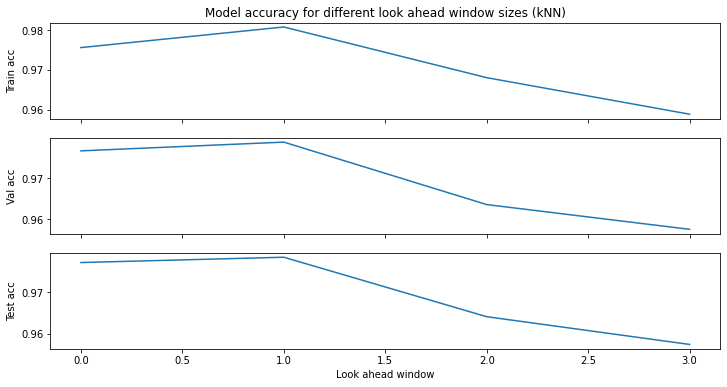

In [654]:
model_scores = np.array(model_scores)
num_cols = model_scores.shape[1]

# Plot each column in a separate subplot
fig, axs = plt.subplots(nrows=num_cols, sharex=True,)
labels = ["Train acc","Val acc","Test acc"]

for i in range(num_cols):
    axs[i].plot(model_scores[:,i])
    axs[i].set_ylabel(labels[i])
axs[-1].set_xlabel("Look ahead window")
fig.set_figheight(6)
fig.set_figwidth(12)
axs[0].set_title("Model accuracy for different look ahead window sizes (kNN)")

In [555]:
X_window = window_states(trajectories)

Number of misclassified concepts: 23
Reward: -719


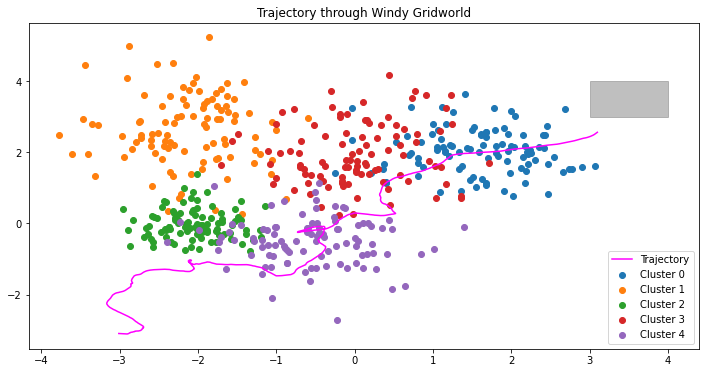

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 2 4 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2
 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3
 3 4 4 4 3 4 3 3 4 4 4 4 

In [591]:
fig, ax2 = plt.subplots(figsize=(12,6))

index = np.random.randint(0,len(X_window))
history = np.array(X_window[index])
concept_history = concepts[index]
predicted_concepts = np.argmax(model1.predict(history), axis=1)

errors = len(np.where((concept_history - predicted_concepts)>0)[0])
print(f"Number of misclassified concepts: {errors}")


# print(f"Concepts visited: {concepts[index]}")
print(f"Reward: {rewards[index]}")
plt.plot(history[:, 0], history[:, 1], color="magenta", label="Trajectory")
rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*100
    end = (i+1)*100
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()


print(concept_history)
print(predicted_concepts)

## $f(c|s,a)$

In [648]:
X_train, X_test, y_train, y_test = generate_states_actions_dataset()
print(X_train.shape)
print(y_train.shape)
model2 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

(322004, 3)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 13s 1ms/step - loss: 0.1548 - categorical_accuracy: 0.9345 - val_loss: 0.1405 - val_categorical_accuracy: 0.9389
Epoch 2/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.1400 - categorical_accuracy: 0.9388 - val_loss: 0.1362 - val_categorical_accuracy: 0.9402
Epoch 3/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.1383 - categorical_accuracy: 0.9391 - val_loss: 0.1346 - val_categorical_accuracy: 0.9407
Epoch 4/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.1372 - categorical_accuracy: 0.9395 - val_loss: 0.1352 - val_categorical_accuracy: 0.9406
Epoch 5/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.1364 - categorical_accuracy: 0.9399 - val_loss: 0.1338 - val_categorical_accuracy: 0.9408
Epoch 6/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.1363 - categorical_accuracy: 0.9395 - val_loss: 0.14

## $f(c|s,\bar{a})$

In [647]:
X_train, X_test, y_train, y_test = generate_states_voted_actions_dataset() # generate_states_actions_dataset()
print(X_train.shape)
print(y_train.shape)
model2 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

(322004, 3)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 17s 2ms/step - loss: 0.1465 - categorical_accuracy: 0.9383 - val_loss: 0.1271 - val_categorical_accuracy: 0.9454
Epoch 2/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.1308 - categorical_accuracy: 0.9433 - val_loss: 0.1347 - val_categorical_accuracy: 0.9407
Epoch 3/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.1293 - categorical_accuracy: 0.9432 - val_loss: 0.1314 - val_categorical_accuracy: 0.9423
Epoch 4/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.1281 - categorical_accuracy: 0.9439 - val_loss: 0.1383 - val_categorical_accuracy: 0.9395
Epoch 5/10
8051/8051 [==============================] - 12s 1ms/step - loss: 0.1273 - categorical_accuracy: 0.9446 - val_loss: 0.1253 - val_categorical_accuracy: 0.9455
Epoch 6/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.1265 - categorical_accuracy: 0.9444 - val_loss: 0.12

## $f(c|s,s')$

In [ ]:
X_train, X_test, y_train, y_test = generate_states_next_states_dataset()
print(X_train.shape)
print(y_train.shape)
model3 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

In [ ]:
score = model3.evaluate(X_test, y_test)
print(f"Test loss: {score[0]} \nTest accuracy: {score[1]}")

## $f(c|s,a,s')$

In [ ]:
X_train, X_test, y_train, y_test = generate_states_next_states_actions_dataset()
print(X_train.shape)
print(y_train.shape)
model4 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history4 = model4.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

In [406]:
score = model4.evaluate(X_test, y_test)
print(f"Test loss: {score[0]} \nTest accuracy: {score[1]}")

2516/2516 [==============================] - 2s 881us/step - loss: 0.1215 - categorical_accuracy: 0.9475
Test loss: 0.12150180339813232 
Test accuracy: 0.9474540948867798


## $f(c|s_w')$

* In this experiment, we are trying to learn a function mapping a window of $w$ future/previous/centered states to concepts.
* It is evident from previous experiments that there is little information pertaining to the concepts in the action history.

In [659]:
X_train, X_test, y_train, y_test = generate_states_next_n_states_dataset(window=20, smoothing_window=5)
print(X_train.shape)
print(y_train.shape)
model5 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history5 = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

(322004, 40)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 12s 1ms/step - loss: 0.0822 - categorical_accuracy: 0.9659 - val_loss: 0.0540 - val_categorical_accuracy: 0.9764
Epoch 2/10
8051/8051 [==============================] - 12s 2ms/step - loss: 0.0529 - categorical_accuracy: 0.9771 - val_loss: 0.0457 - val_categorical_accuracy: 0.9802
Epoch 3/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.0475 - categorical_accuracy: 0.9796 - val_loss: 0.0487 - val_categorical_accuracy: 0.9779
Epoch 4/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.0444 - categorical_accuracy: 0.9805 - val_loss: 0.0677 - val_categorical_accuracy: 0.9722
Epoch 5/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.0424 - categorical_accuracy: 0.9815 - val_loss: 0.0380 - val_categorical_accuracy: 0.9834
Epoch 6/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.0421 - categorical_accuracy: 0.9817 - val_loss: 0.0

In [559]:
history5.history["val_categorical_accuracy"][-1]
score = model5.evaluate(X_test, y_test)
print(f"Test loss: {score[0]} \nTest accuracy: {score[1]}")

2571/2571 [==============================] - 2s 736us/step - loss: 0.1597 - categorical_accuracy: 0.9272
Test loss: 0.15970700979232788 
Test accuracy: 0.9271542429924011


In [560]:

model_scores = []
for w_size in [1,5,10,15,20]:
    scores = np.zeros((3))
    X_train, X_test, y_train, y_test = generate_states_next_n_states_dataset(window=w_size, smoothing_window=5)
    print(X_train.shape)
    print(y_train.shape)
    model5 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
    history5 = model5.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.2)
    score = model5.evaluate(X_test, y_test)
    scores[0] = history5.history["categorical_accuracy"][-1]
    scores[1] = history5.history["val_categorical_accuracy"][-1]
    scores[2] = score[1]
    model_scores.append(scores)

model_scores
    


(329024, 2)
(329024, 5)
Epoch 1/8
8226/8226 [==============================] - 11s 1ms/step - loss: 0.2252 - categorical_accuracy: 0.9042 - val_loss: 0.2112 - val_categorical_accuracy: 0.9068
Epoch 2/8
8226/8226 [==============================] - 12s 2ms/step - loss: 0.2095 - categorical_accuracy: 0.9087 - val_loss: 0.2108 - val_categorical_accuracy: 0.9078
Epoch 3/8
8226/8226 [==============================] - 13s 2ms/step - loss: 0.2076 - categorical_accuracy: 0.9093 - val_loss: 0.2113 - val_categorical_accuracy: 0.9065
Epoch 4/8
8226/8226 [==============================] - 13s 2ms/step - loss: 0.2060 - categorical_accuracy: 0.9097 - val_loss: 0.2046 - val_categorical_accuracy: 0.9110
Epoch 5/8
8226/8226 [==============================] - 12s 1ms/step - loss: 0.2047 - categorical_accuracy: 0.9102 - val_loss: 0.2012 - val_categorical_accuracy: 0.9121
Epoch 6/8
8226/8226 [==============================] - 9s 1ms/step - loss: 0.2037 - categorical_accuracy: 0.9111 - val_loss: 0.2025 - va

[array([0.91133237, 0.91099459, 0.91374487]),
 array([0.91554558, 0.91634375, 0.91789049]),
 array([0.92370611, 0.92082667, 0.92226708]),
 array([0.92858416, 0.9314186 , 0.93067986]),
 array([0.93072689, 0.92500567, 0.92547655]),
 array([0.93222374, 0.93590152, 0.93335438]),
 array([0.93358004, 0.92641896, 0.92619383]),
 array([0.93470454, 0.93333334, 0.933245  ]),
 array([0.9359051 , 0.93293822, 0.93482542]),
 array([0.93558973, 0.9397006 , 0.9394573 ]),
 array([0.93671429, 0.93921435, 0.93888593]),
 array([0.93682069, 0.93895602, 0.93813217]),
 array([0.93672949, 0.93784666, 0.93714744]),
 array([0.93693846, 0.93907756, 0.938582  ]),
 array([0.9361558 , 0.94027811, 0.94140244])]

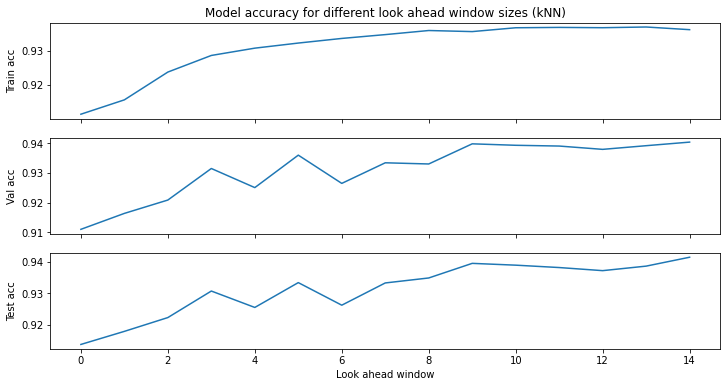

In [562]:
# Get the number of columns in the matrix
model_scores = np.array(model_scores)
num_cols = model_scores.shape[1]

# Plot each column in a separate subplot
fig, axs = plt.subplots(nrows=num_cols, sharex=True,)
labels = ["Train acc","Val acc","Test acc"]

for i in range(num_cols):
    axs[i].plot(model_scores[:,i])
    axs[i].set_ylabel(labels[i])
axs[-1].set_xlabel("Look ahead window")
fig.set_figheight(6)
fig.set_figwidth(12)
axs[0].set_title("Model accuracy for different look ahead window sizes (kNN)")
    
plt.show()